# Сборный проект — 2

## Описание проекта

HR-аналитики компании «Работа с заботой» используют машинное обучение для решения двух ключевых задач:

1)Прогнозирование удовлетворённости сотрудников: Создать модель, предсказывающую уровень удовлетворённости работой (от 0 до 1) на основе характеристик сотрудников. Это важно, так как удовлетворённость влияет на увольнения.

2)Прогнозирование увольнений сотрудников: Создать модель, предсказывающую вероятность увольнения сотрудника на основе данных о нём. Это поможет предотвратить внезапные увольнения, которые несут риски для бизнеса.

Цель – помочь бизнесу оптимизировать управление персоналом, избегая финансовых потерь и оттока сотрудников с помощью точных прогнозов.

## Задача 1: предсказание уровня удовлетворённости сотрудника

In [1]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving test_target_job_satisfaction_rate.csv to test_target_job_satisfaction_rate.csv
Saving test_features.csv to test_features.csv
Saving train_job_satisfaction_rate.csv to train_job_satisfaction_rate.csv


In [4]:
pd.set_option('display.max_columns', None)

## Шаг 1. Загрузка данных

In [5]:
train = pd.read_csv('train_job_satisfaction_rate.csv')
X_test = pd.read_csv('test_features.csv')
y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')

In [6]:
display(train.head())
display(X_test.head())
display(y_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [7]:
train.set_index('id', inplace=True)
X_test.set_index('id', inplace=True)
y_test.set_index('id', inplace=True)

In [8]:
train.info()
X_test.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   ob

In [9]:
def get_categorical_unique_values(df, df_name):
    # Преобразуем supervisor_evaluation в категориальный тип, если он числовой
    if 'supervisor_evaluation' in df.columns:
        df['supervisor_evaluation'] = df['supervisor_evaluation'].astype('category')

    # Выбираем только категориальные столбцы
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Выводим название DataFrame
    print(f"Уникальные значения для категориальных столбцов в DataFrame '{df_name}':")
    print('-' * 50)

    # Проходим по каждому категориальному столбцу и выводим уникальные значения
    for column in categorical_columns:
        print(f"Столбец '{column}':")
        print(df[column].unique())
        print('-' * 50)

In [10]:
get_categorical_unique_values(train, 'train')
get_categorical_unique_values(X_test, 'X_test')

Уникальные значения для категориальных столбцов в DataFrame 'train':
--------------------------------------------------
Столбец 'dept':
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
--------------------------------------------------
Столбец 'level':
['junior' 'middle' 'sinior' nan]
--------------------------------------------------
Столбец 'workload':
['medium' 'high' 'low']
--------------------------------------------------
Столбец 'last_year_promo':
['no' 'yes']
--------------------------------------------------
Столбец 'last_year_violations':
['no' 'yes']
--------------------------------------------------
Столбец 'supervisor_evaluation':
[1, 5, 2, 3, 4]
Categories (5, int64): [1, 2, 3, 4, 5]
--------------------------------------------------
Уникальные значения для категориальных столбцов в DataFrame 'X_test':
--------------------------------------------------
Столбец 'dept':
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
------------------------------------

In [11]:
print(train.duplicated().sum())
train = train.drop_duplicates()

245


In [12]:
train.loc[train['level'] == 'sinior', 'level'] = 'senior'
X_test.loc[X_test['level'] == 'sinior', 'level'] = 'senior'

Были удалены явные дубликаты, исправлены опечатки.

## Шаг 3. Исследовательский анализ данных

Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

In [13]:
display(train.describe())
display(X_test.describe())
display(y_test.describe())

,employment_years,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000
mean,3.817044,34457.416778,0.532554
std,2.557142,15050.643870,0.226393
min,1.000000,12000.000000,0.030000
25%,2.000000,22800.000000,0.350000
50%,3.000000,31200.000000,0.550000
75%,6.000000,44400.000000,0.710000
max,10.000000,98400.000000,1.000000


,employment_years,salary
count,2000.000000,2000.000000
mean,3.666500,34066.800000
std,2.537222,15398.436729
min,1.000000,12000.000000
25%,1.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,96000.000000


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


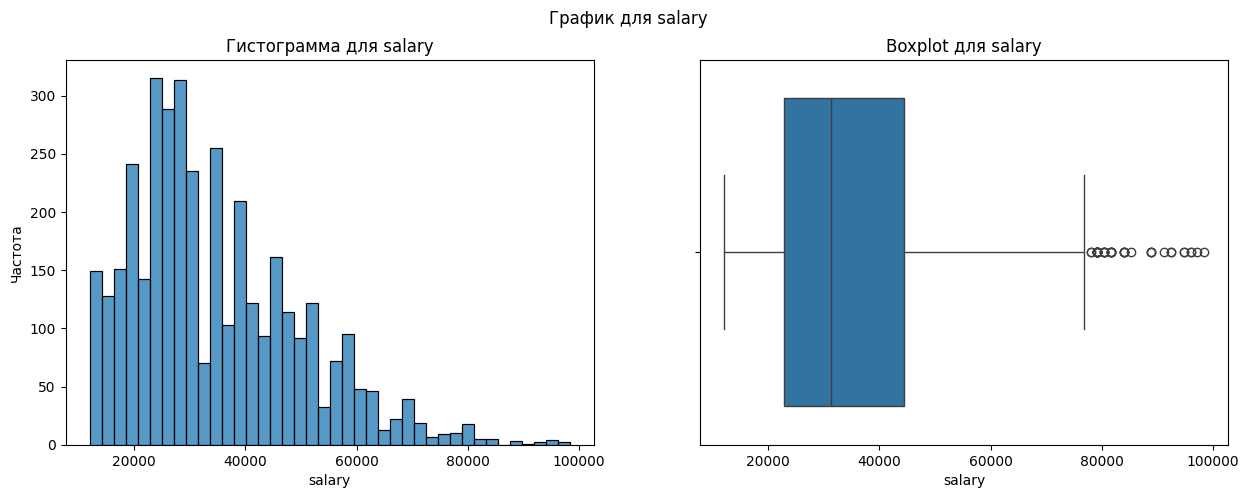

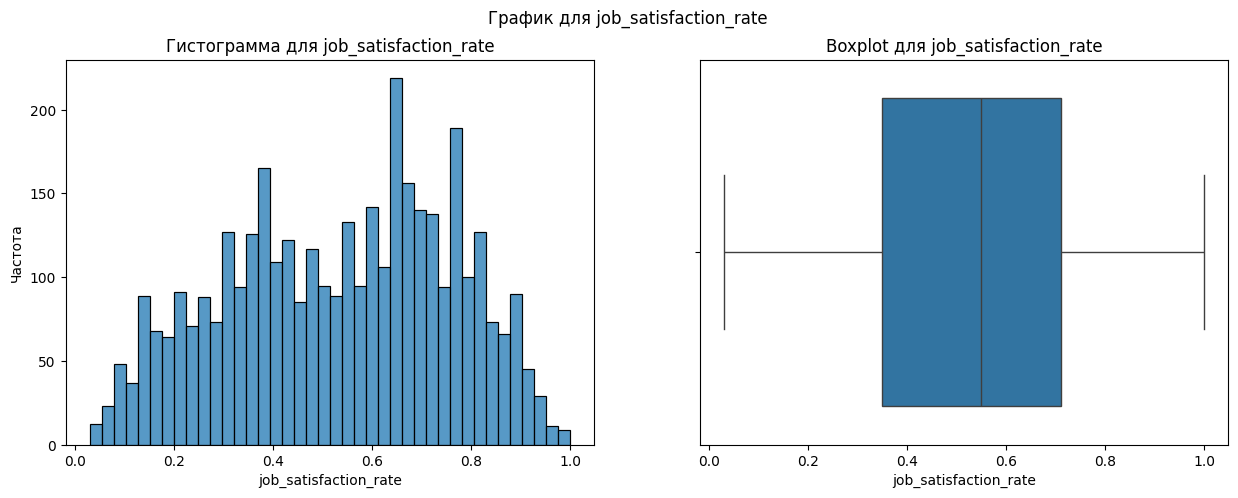

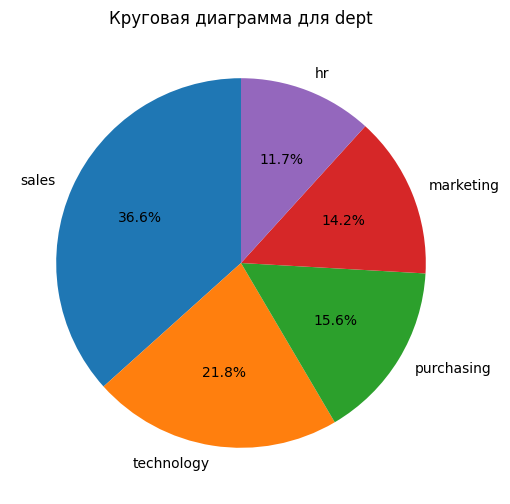

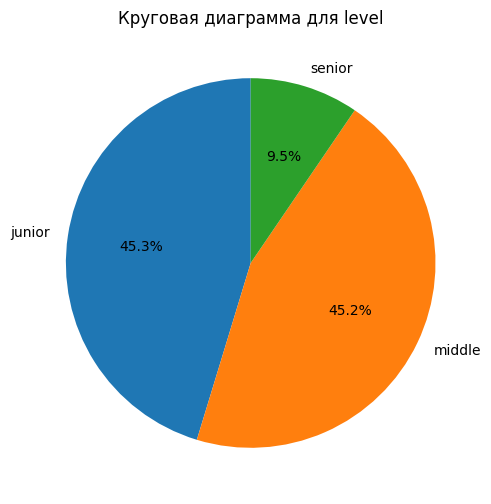

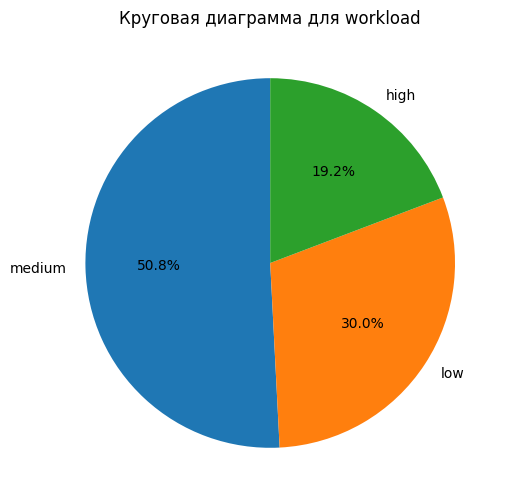

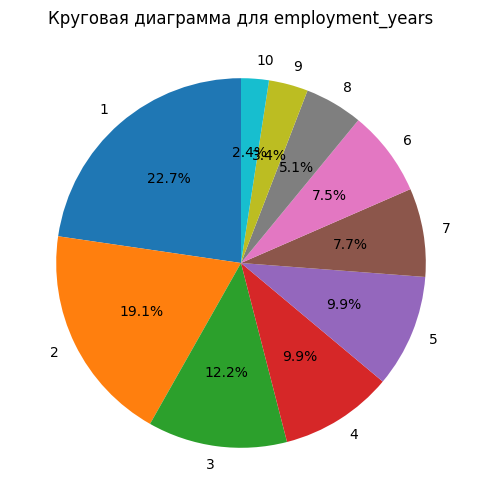

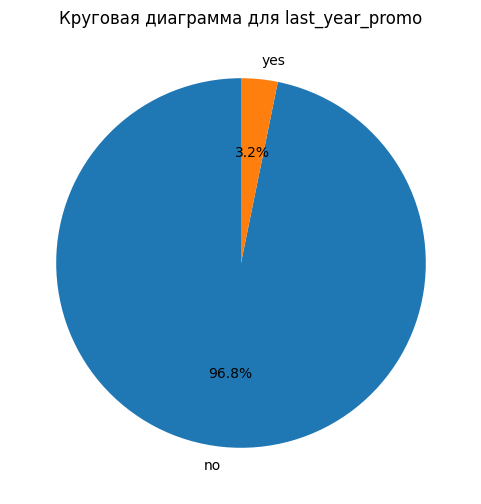

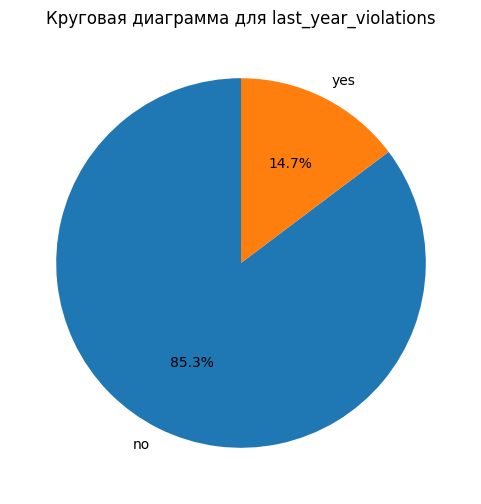

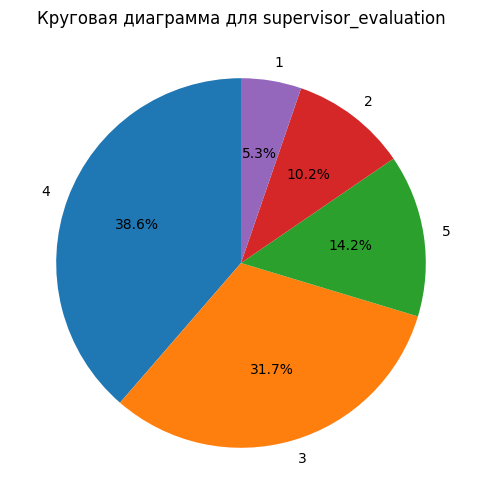

In [14]:
numerical_cols = ['salary', 'job_satisfaction_rate']
categorical_cols = ['dept',
                    'level',
                    'workload',
                    'employment_years',
                    'last_year_promo',
                    'last_year_violations',
                    'supervisor_evaluation']

# Построение гистограмм и boxplot для числовых столбцов
for col in numerical_cols:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=train[col], ax=axs[0], bins=40)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Частота')
    axs[0].set_title(f'Гистограмма для {col}')

    # Исправленный boxplot
    sns.boxplot(x=train[col], ax=axs[1])  # Передаем данные через параметр x
    axs[1].set_xlabel(col)
    axs[1].set_title(f'Boxplot для {col}')

    fig.suptitle(f'График для {col}')
    plt.show()

# Создаем круговые диаграммы для каждого категориального столбца
for col in categorical_cols:
    plt.figure(figsize=(6, 6))  # Создаем новый рисунок для каждого столбца
    counts = train[col].value_counts()  # Считаем частоту каждого значения
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)  # Создаем круговую диаграмму
    plt.title(f'Круговая диаграмма для {col}')
    plt.ylabel(None)  # Удаляем подпись оси y
    plt.show()

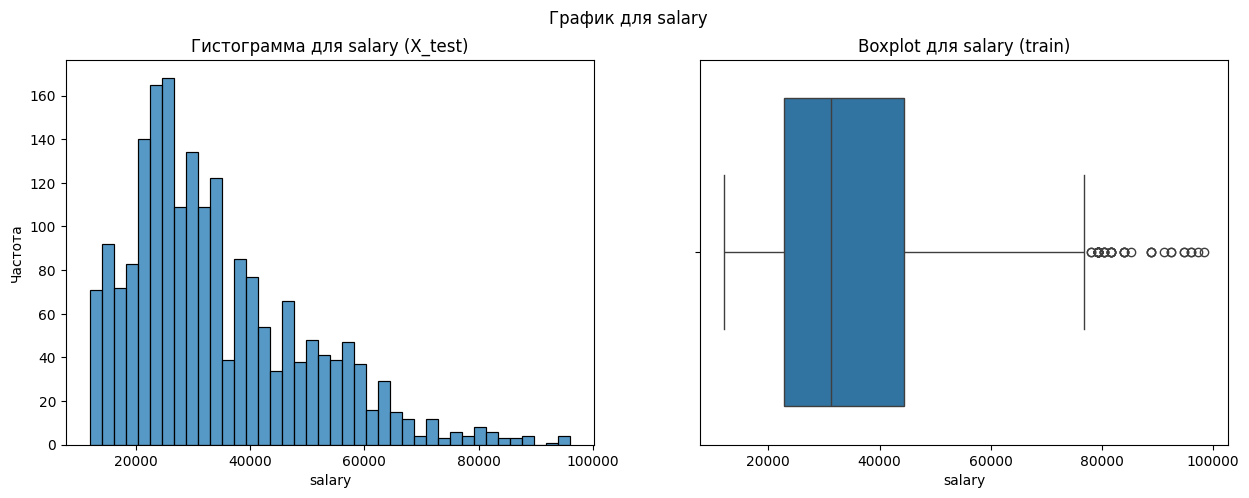

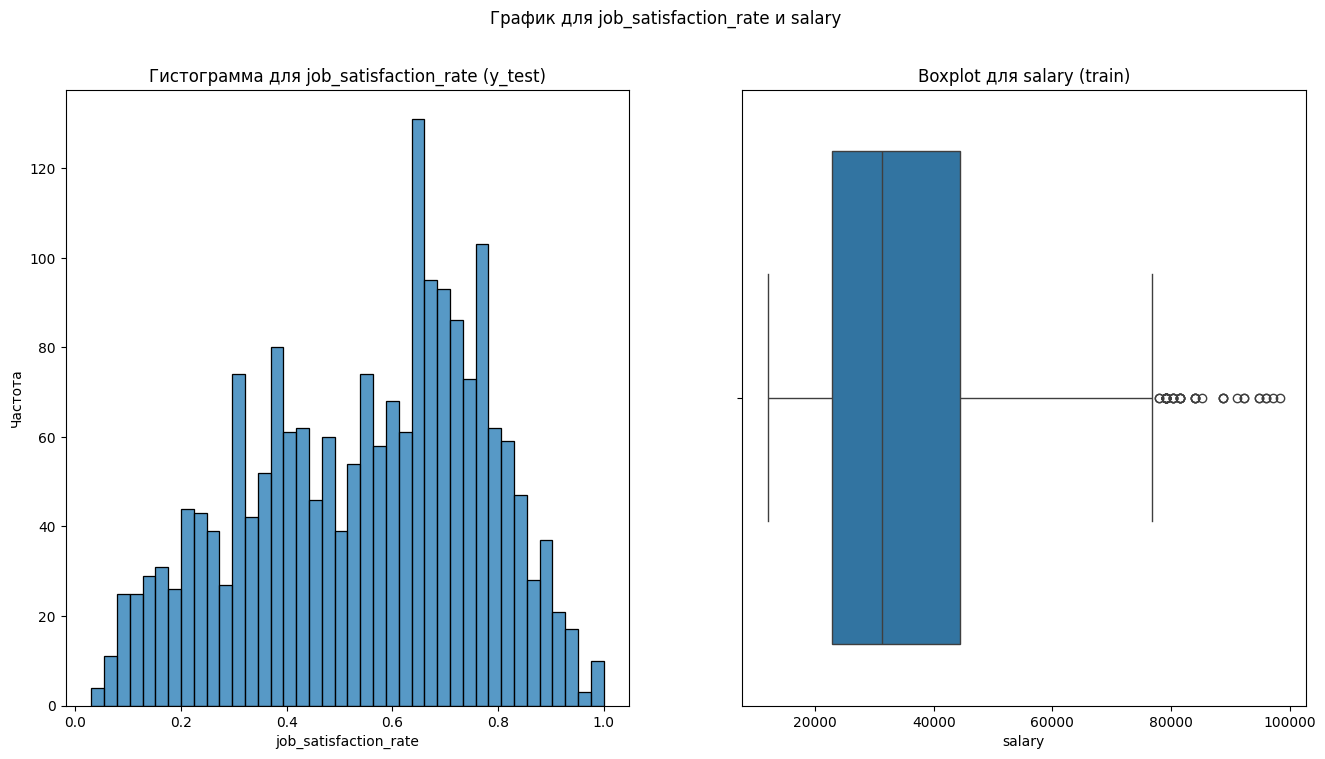

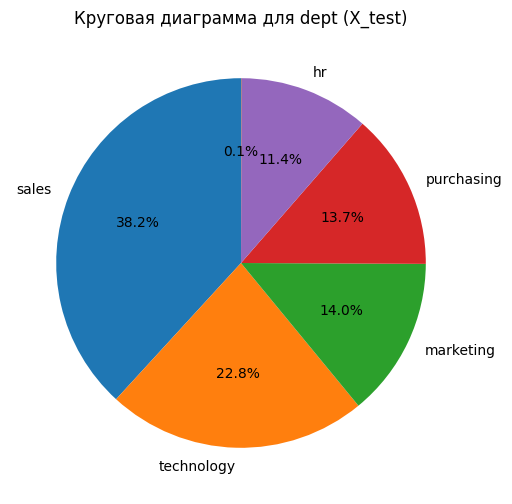

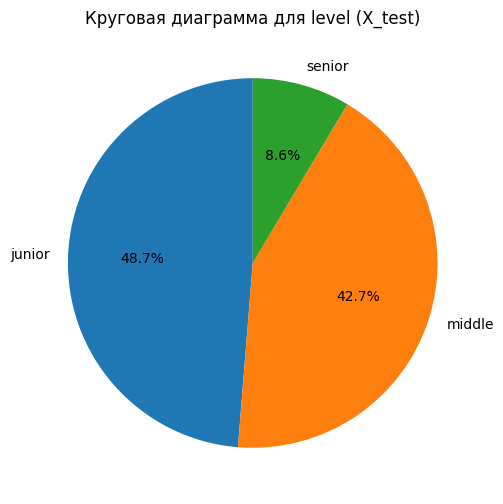

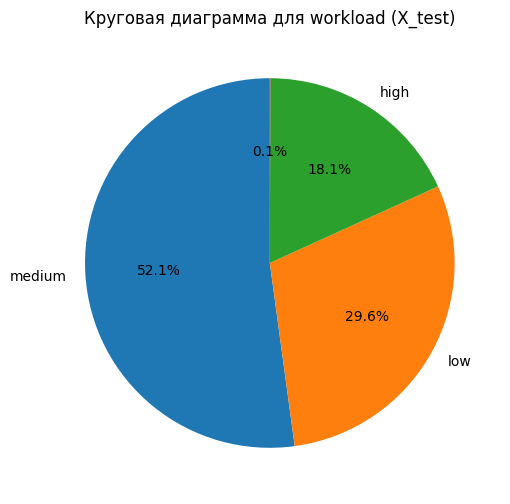

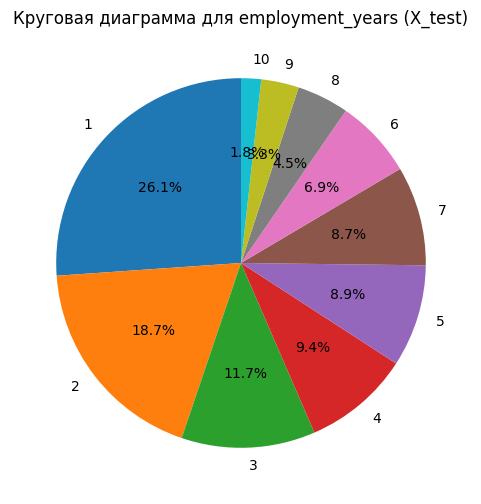

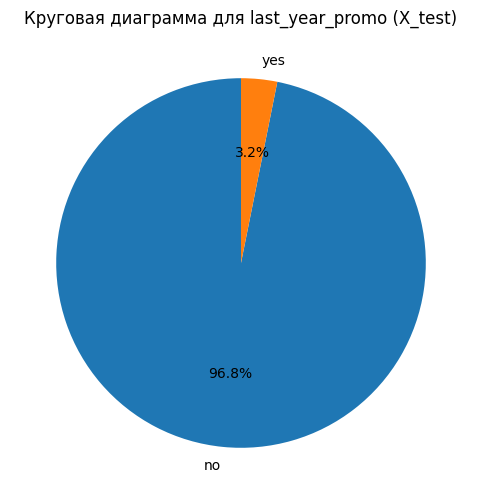

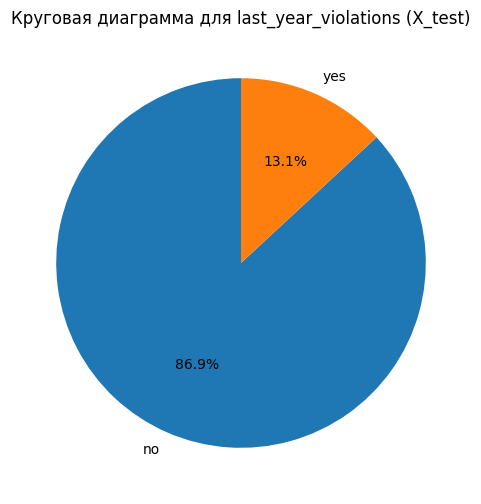

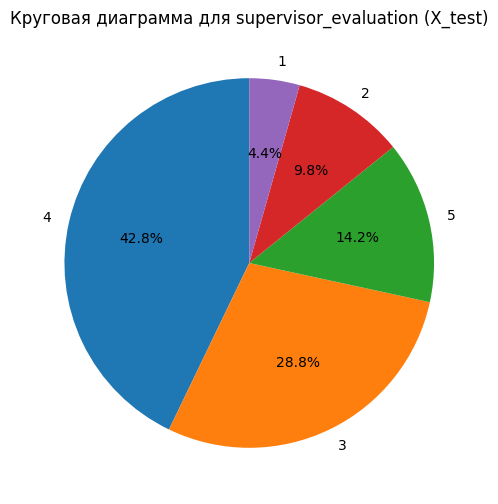

In [15]:
numerical_cols = ['salary']
categorical_cols = ['dept',
                    'level',
                    'workload',
                    'employment_years',
                    'last_year_promo',
                    'last_year_violations',
                    'supervisor_evaluation']

# Построение гистограмм и boxplot для числовых столбцов
for col in numerical_cols:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Гистограмма для X_test
    sns.histplot(data=X_test[col], ax=axs[0], bins=40)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Частота')
    axs[0].set_title(f'Гистограмма для {col} (X_test)')

    # Boxplot для train
    sns.boxplot(x=train[col], ax=axs[1])  # Исправлено: используем параметр x
    axs[1].set_xlabel(col)
    axs[1].set_title(f'Boxplot для {col} (train)')

    fig.suptitle(f'График для {col}')
    plt.show()

# Отдельный график для job_satisfaction_rate
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Гистограмма для y_test (job_satisfaction_rate)
sns.histplot(data=y_test, x='job_satisfaction_rate', ax=axs[0], bins=40)
axs[0].set_xlabel('job_satisfaction_rate')
axs[0].set_ylabel('Частота')
axs[0].set_title(f'Гистограмма для job_satisfaction_rate (y_test)')

# Boxplot для train (salary)
sns.boxplot(x=train['salary'], ax=axs[1])  # Исправлено: используем параметр x
axs[1].set_xlabel('salary')
axs[1].set_title(f'Boxplot для salary (train)')

fig.suptitle(f'График для job_satisfaction_rate и salary')
plt.show()

# Создаем круговые диаграммы для каждого категориального столбца
for col in categorical_cols:
    plt.figure(figsize=(6, 6))  # Создаем новый рисунок для каждого столбца
    counts = X_test[col].value_counts()  # Считаем частоту каждого значения
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)  # Создаем круговую диаграмму
    plt.title(f'Круговая диаграмма для {col} (X_test)')
    plt.ylabel(None)  # Удаляем подпись оси y
    plt.show()

Тренировочная и тестовая выборка в целом похожи друг на друга. Большенство работает в отделе продаж. 50% джунов, Половина сотрудников загружены средне.

### Анализ корреляции

In [16]:
train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


interval columns not set, guessing: ['employment_years', 'salary', 'job_satisfaction_rate']


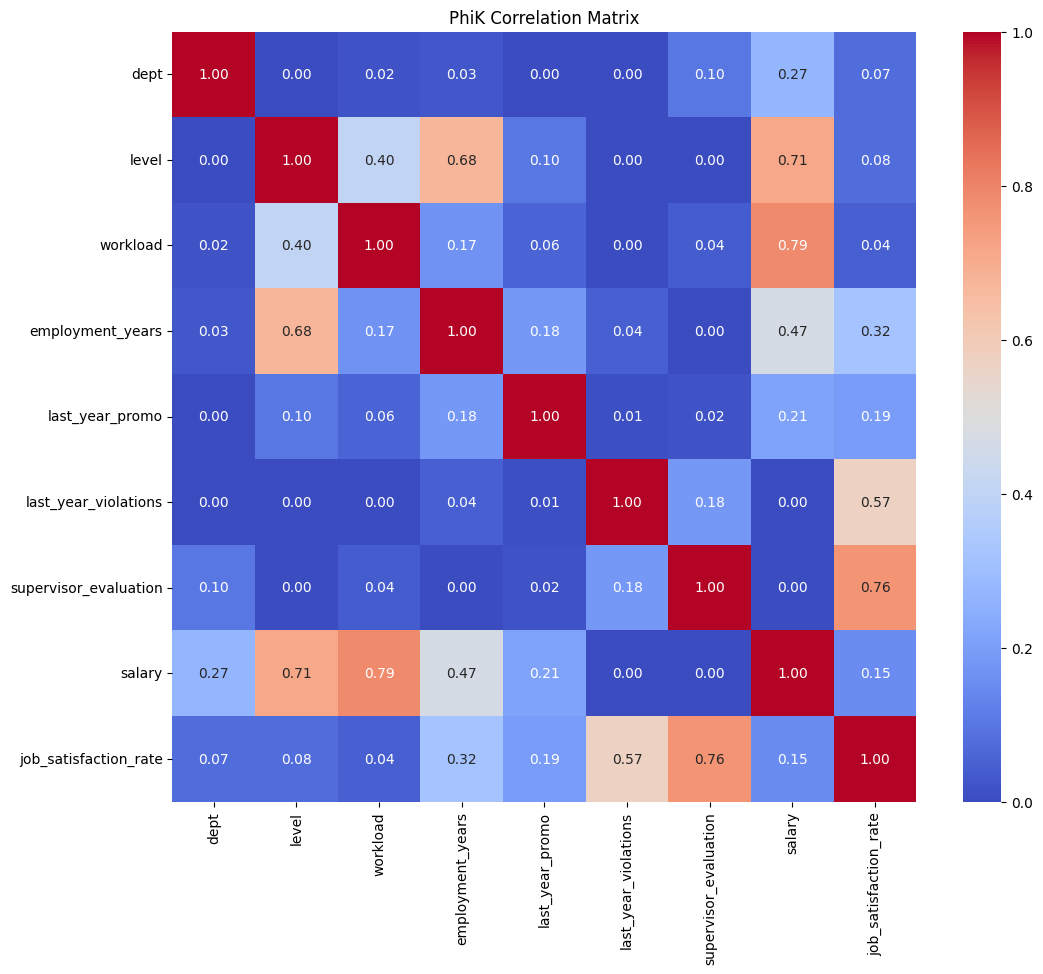

In [17]:
phik_matrix_df = train.phik_matrix()

# Визуализируем матрицу PhiK
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PhiK Correlation Matrix")
plt.show()

Видим хорошую кореляцию между оценкой и рейтингом.

## Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [18]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

y = train['job_satisfaction_rate']
X = train.drop(['job_satisfaction_rate'], axis = 1)

In [19]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value',  # Recommended for robustness
                unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Подготовили данные для пайплайна, далее обучим модель.

## Шаг 5. Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).
Критерий успеха: SMAPE ≤15 на тестовой выборке.
В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы.

In [20]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 1.0, 10.0],
        'models__solver': ['saga', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [None, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': [3, 5, 7],
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [21]:
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape = make_scorer(smape_score, greater_is_better = False)

In [22]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring=smape,
    n_jobs=-1,
    error_score='raise'
)
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                          'models__n_estimators': [50, 100, 200],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsRegressor()],
                          'models__n_neighbors': [3, 5, 7],
                          'models__weights': ['uniform', 'distance'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [23]:
# Получаем результаты кросс-валидации
cv_results = pd.DataFrame(grid_search.cv_results_)

# Сортируем результаты по убыванию SMAPE (так как SMAPE минимизируется, берем отрицательное значение)
cv_results['mean_test_score'] = -cv_results['mean_test_score'] # Переводим обратно к положительным значениям
cv_results = cv_results.sort_values('mean_test_score', ascending=True)

# Выводим топ-10 моделей
print("Топ-10 моделей:")
print(cv_results[['params', 'mean_test_score']].head(10))

# Выводим лучшую модель и метрику
print(f'Лучшая модель: {grid_search.best_estimator_}')
print(f'Метрика лучшей модели на кросс-валидации: {-grid_search.best_score_}')

Топ-10 моделей:
                                                params  mean_test_score
145  {'models': RandomForestRegressor(random_state=...        13.812965
148  {'models': RandomForestRegressor(random_state=...        13.813501
146  {'models': RandomForestRegressor(random_state=...        13.835040
149  {'models': RandomForestRegressor(random_state=...        13.835102
147  {'models': RandomForestRegressor(random_state=...        13.863939
144  {'models': RandomForestRegressor(random_state=...        13.865652
142  {'models': RandomForestRegressor(random_state=...        13.880710
143  {'models': RandomForestRegressor(random_state=...        13.907326
141  {'models': RandomForestRegressor(random_state=...        13.936589
163  {'models': RandomForestRegressor(random_state=...        14.621539
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                           

In [24]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()

In [25]:
y_predict = grid_search.predict(X_test)
y_predict

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0.82840333, 0.84398929, 0.77535369, ..., 0.50276   , 0.43913667,
       0.33749714])

In [26]:
smape_score(np.array(y_test['job_satisfaction_rate']), y_predict)

np.float64(12.351384051127615)

## Шаг 6. Вывод

Обучили несколько моделей, лучшая 'models', RandomForestRegressor(random_state=42), с метрикой SMAPE равной 14 на тренеровочной выборке. Тестовая выборка показала результат 12. Что меньше 15 и подходит нам по заданию.

## Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

## Шаг 1. Загрузка данных

In [27]:
# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving test_features.csv to test_features (1).csv
Saving test_target_quit.csv to test_target_quit.csv
Saving train_quit.csv to train_quit.csv


In [28]:
train2 = pd.read_csv('train_quit.csv')
X_test2 = pd.read_csv('test_features.csv')
y_test2 = pd.read_csv('test_target_quit.csv')

In [29]:
display(train2.head())
display(X_test2.head())
display(y_test2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Шаг 2. Предобработка данных

In [30]:
train2.set_index('id', inplace=True)
X_test2.set_index('id', inplace=True)
y_test2.set_index('id', inplace=True)

In [31]:
train2.info()
X_test2.info()
y_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level        

In [32]:
get_categorical_unique_values(train2, 'train')
get_categorical_unique_values(X_test2, 'X_test')

Уникальные значения для категориальных столбцов в DataFrame 'train':
--------------------------------------------------
Столбец 'dept':
['sales' 'purchasing' 'marketing' 'technology' 'hr']
--------------------------------------------------
Столбец 'level':
['middle' 'junior' 'sinior']
--------------------------------------------------
Столбец 'workload':
['high' 'medium' 'low']
--------------------------------------------------
Столбец 'last_year_promo':
['no' 'yes']
--------------------------------------------------
Столбец 'last_year_violations':
['no' 'yes']
--------------------------------------------------
Столбец 'supervisor_evaluation':
[4, 1, 3, 5, 2]
Categories (5, int64): [1, 2, 3, 4, 5]
--------------------------------------------------
Столбец 'quit':
['no' 'yes']
--------------------------------------------------
Уникальные значения для категориальных столбцов в DataFrame 'X_test':
--------------------------------------------------
Столбец 'dept':
['marketing' 'hr' 'sales'

In [34]:
print(train2.duplicated().sum())
train2 = train2.drop_duplicates()

1413


In [35]:
train2.loc[train2['level'] == 'sinior', 'level'] = 'senior'
X_test2.loc[X_test2['level'] == 'sinior', 'level'] = 'senior'

 Были удалены явные дубликаты, исправлены опечатки.

## Шаг 3. Исследовательский анализ данных

In [36]:
display(train2.describe())
display(X_test2.describe())
display(y_test2.describe())

,employment_years,salary
count,2587.000000,2587.000000
mean,4.213375,37107.692308
std,2.601105,16267.354906
min,1.000000,12000.000000
25%,2.000000,24000.000000
50%,4.000000,33600.000000
75%,6.000000,46800.000000
max,10.000000,96000.000000


,employment_years,salary
count,2000.000000,2000.000000
mean,3.666500,34066.800000
std,2.537222,15398.436729
min,1.000000,12000.000000
25%,1.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,96000.000000


,quit
count,2000
unique,2
top,no
freq,1436


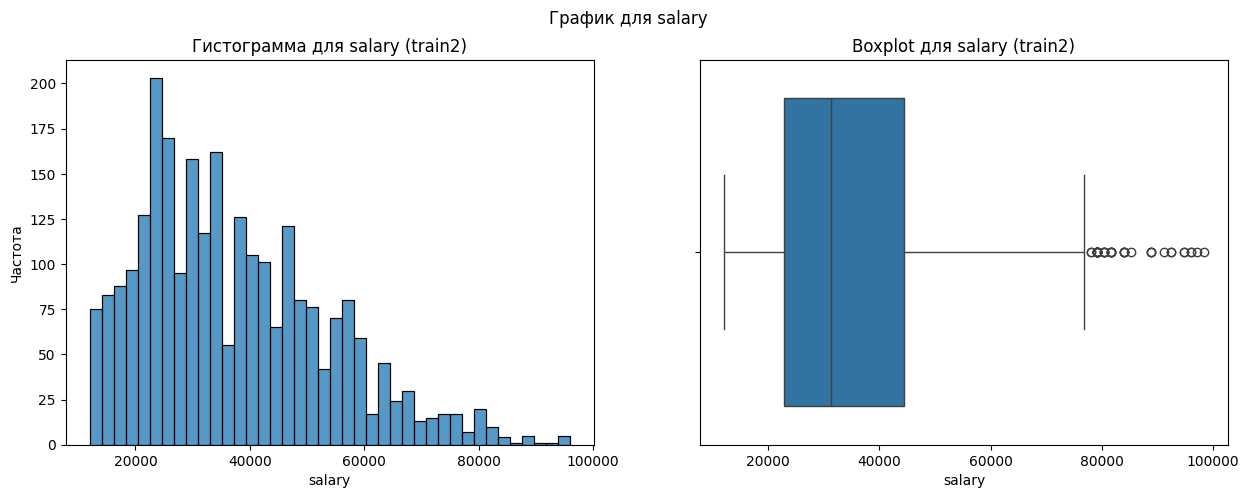

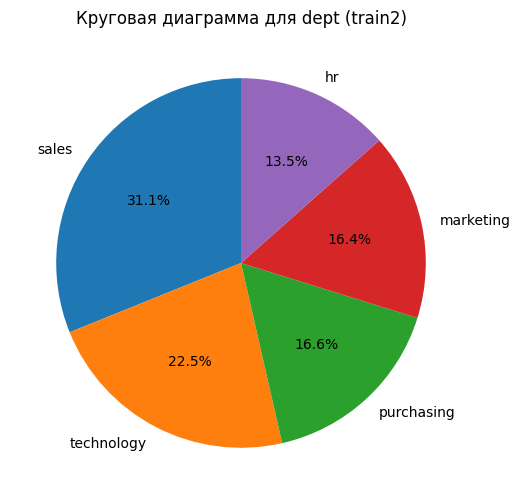

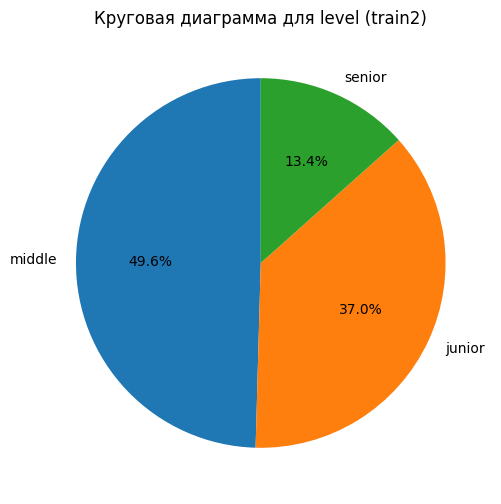

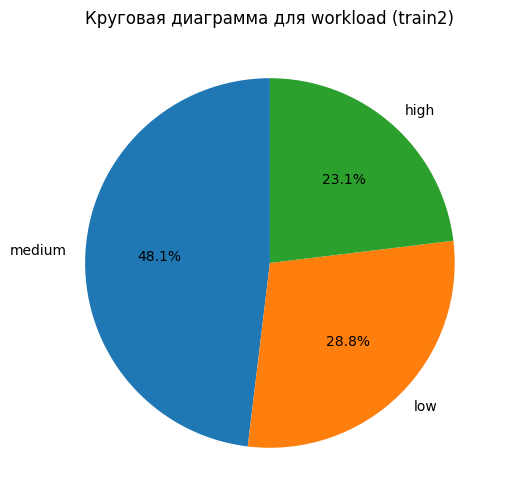

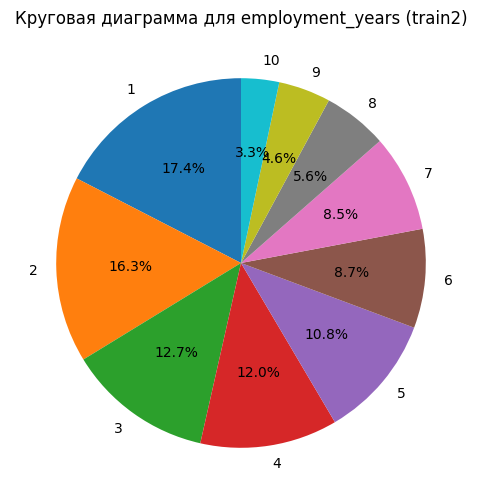

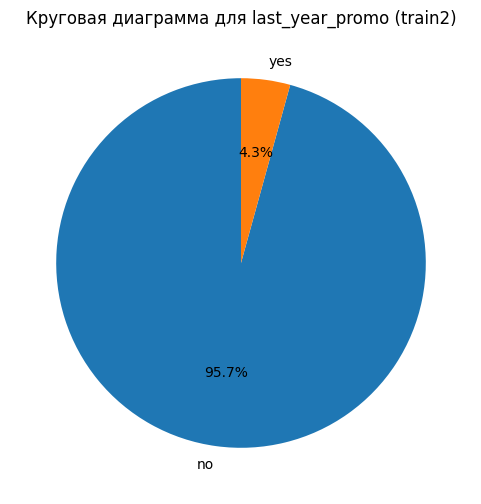

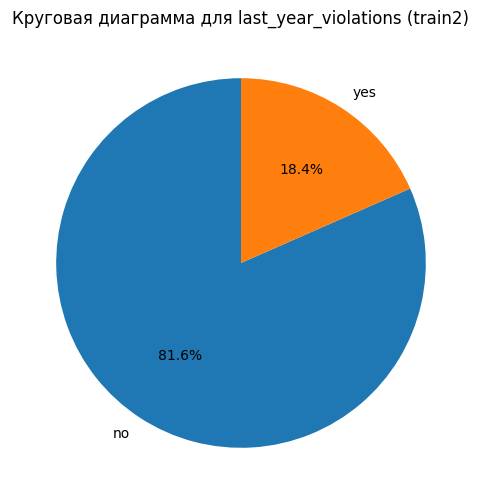

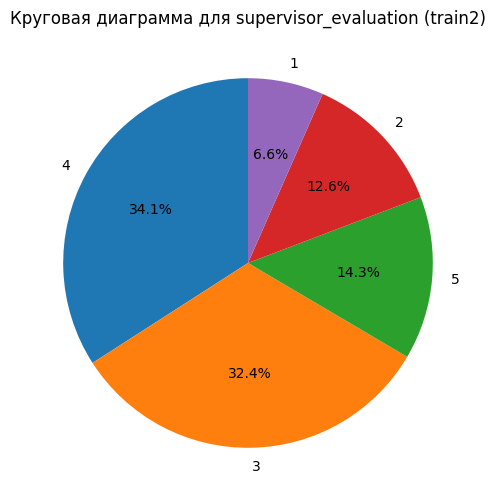

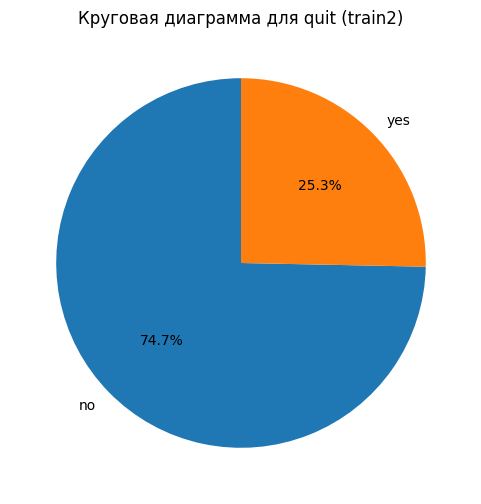

In [37]:
numerical_cols = ['salary']
categorical_cols = ['dept',
                    'level',
                    'workload',
                    'employment_years',
                    'last_year_promo',
                    'last_year_violations',
                    'supervisor_evaluation',
                    'quit']

# Построение гистограмм и boxplot для числовых столбцов
for col in numerical_cols:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Гистограмма для train2
    sns.histplot(data=train2[col], ax=axs[0], bins=40)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Частота')
    axs[0].set_title(f'Гистограмма для {col} (train2)')

    # Boxplot для train
    sns.boxplot(x=train[col], ax=axs[1])  # Исправлено: используем параметр x
    axs[1].set_xlabel(col)
    axs[1].set_title(f'Boxplot для {col} (train2)')

    fig.suptitle(f'График для {col}')
    plt.show()

# Создаем круговые диаграммы для каждого категориального столбца
for col in categorical_cols:
    plt.figure(figsize=(6, 6))  # Создаем новый рисунок для каждого столбца
    counts = train2[col].value_counts()  # Считаем частоту каждого значения
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)  # Создаем круговую диаграмму
    plt.title(f'Круговая диаграмма для {col} (train2)')
    plt.ylabel(None)  # Удаляем подпись оси y
    plt.show()

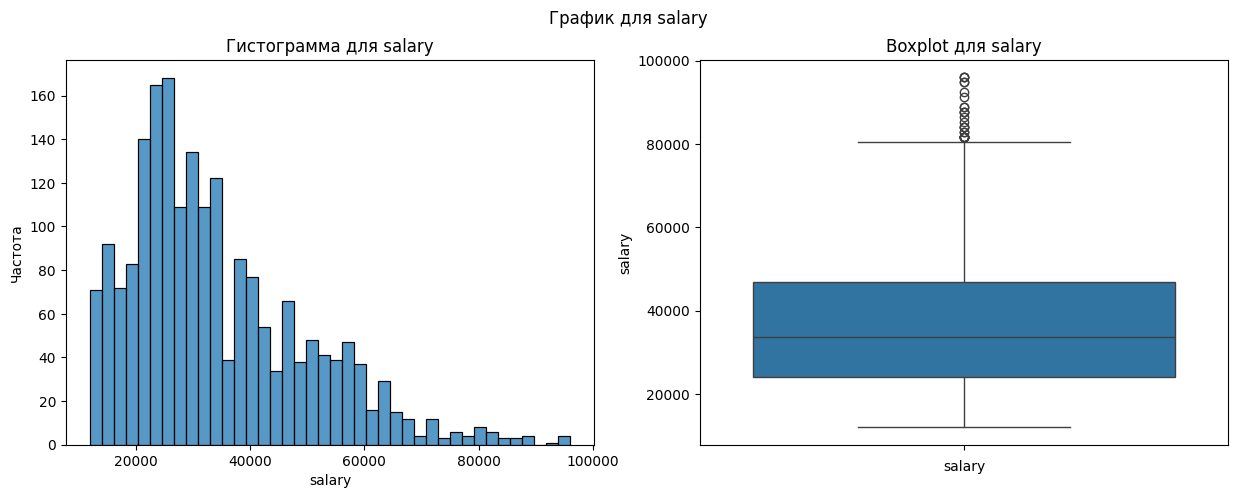

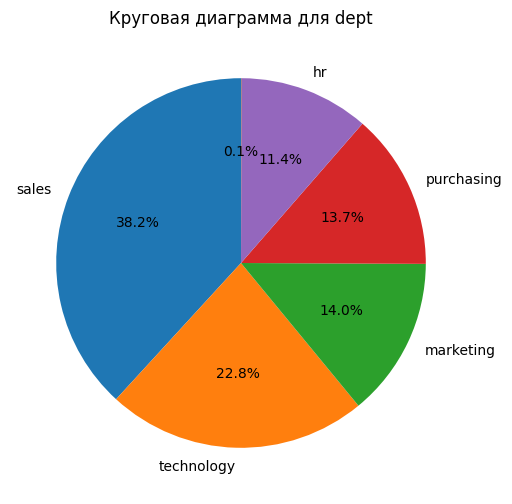

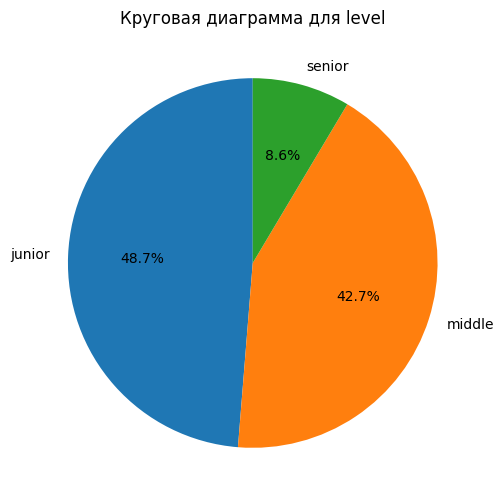

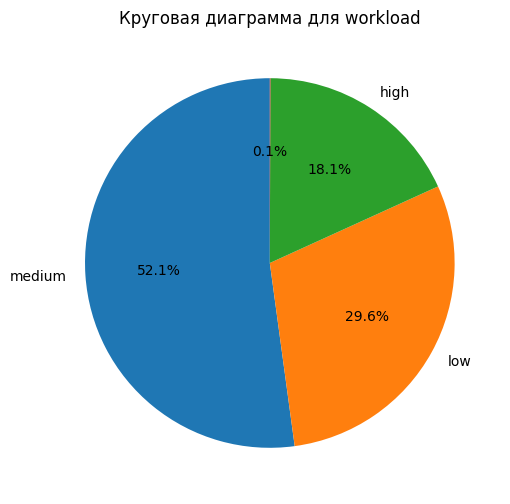

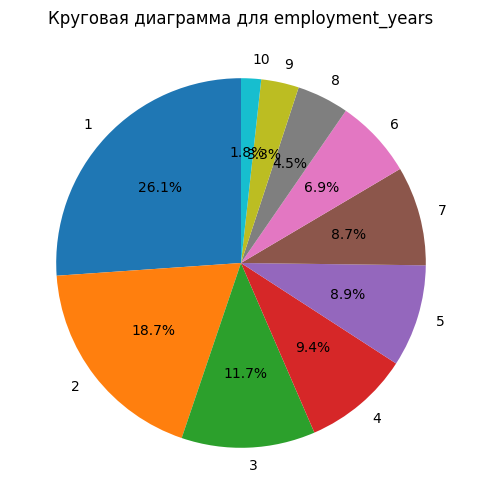

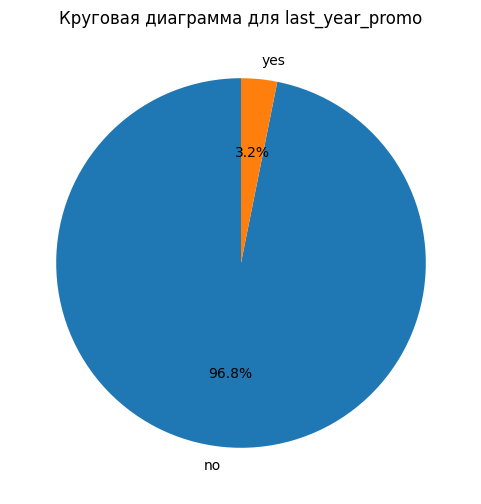

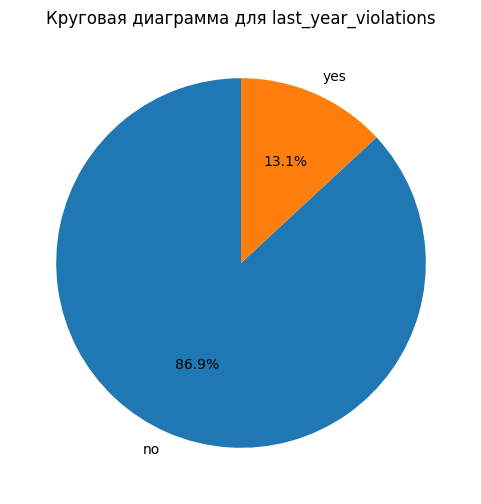

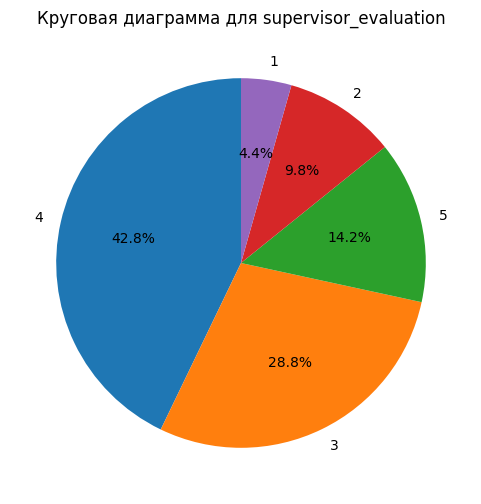

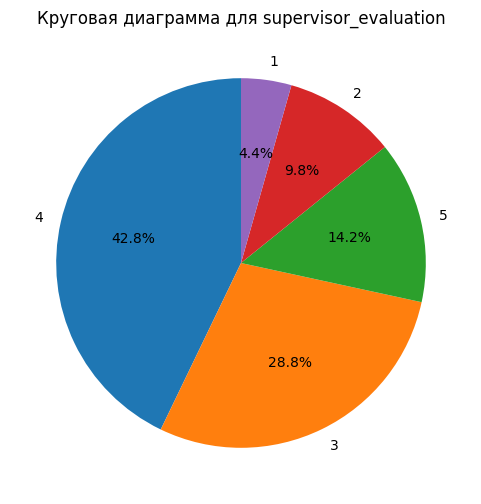

In [38]:
numerical_cols = ['salary']
categorical_cols = ['dept',
                    'level',
                    'workload',
                    'employment_years',
                    'last_year_promo',
                    'last_year_violations',
                    'supervisor_evaluation']

# Построение графиков для числовых столбцов
for col in numerical_cols:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Гистограмма
    sns.histplot(data=X_test2[col], ax=axs[0], bins=40)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Частота')
    axs[0].set_title(f'Гистограмма для {col}')

    # Boxplot
    sns.boxplot(y=train2[col], ax=axs[1])  # Используем y= для одномерного boxplot
    axs[1].set_xlabel(col)
    axs[1].set_title(f'Boxplot для {col}')

    fig.suptitle(f'График для {col}')
    plt.show()

# Построение круговых диаграмм для категориальных столбцов
for col in categorical_cols:
    plt.figure(figsize=(6, 6))  # Создаем новый рисунок для каждого столбца
    counts = X_test[col].value_counts()  # Считаем частоту каждого значения
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)  # Создаем круговую диаграмму
    plt.title(f'Круговая диаграмма для {col}')
    plt.ylabel(None)  # Удаляем подпись оси y
    plt.show()

# Дополнительная круговая диаграмма (если нужно)
plt.figure(figsize=(6, 6))  # Создаем новый рисунок для каждого столбца
counts = X_test2[col].value_counts()  # Считаем частоту каждого значения
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)  # Создаем круговую диаграмму
plt.title(f'Круговая диаграмма для {col}')
plt.ylabel(None)  # Удаляем подпись оси y
plt.show()

Промежуточный вывод: Выбросов не обнаружено, продажников больше, джуны занимают около 50%, нагрузка средняя.

### Анализ кореляции

interval columns not set, guessing: ['employment_years', 'salary']


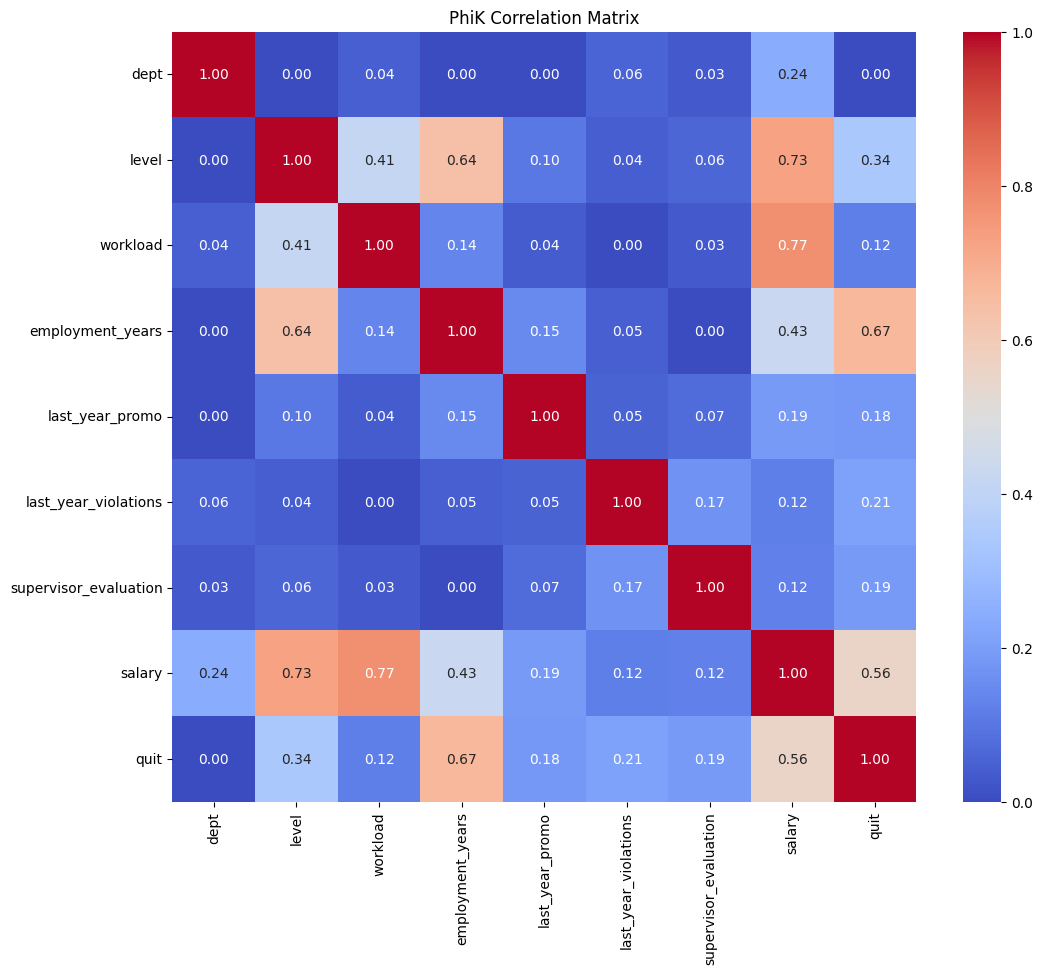

In [39]:
phik_matrix_df = train2.phik_matrix()

# Визуализируем матрицу PhiK
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PhiK Correlation Matrix")
plt.show()

Здесь сильных зависимостей с целевым признаком не видно.

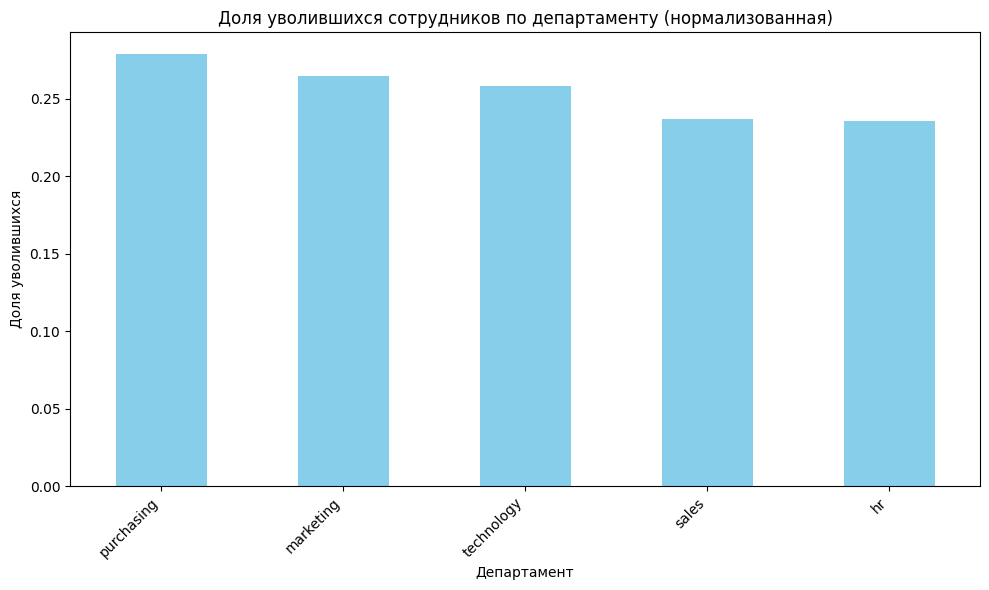

dept
purchasing    0.279070
marketing     0.264775
technology    0.258176
sales         0.237267
hr            0.235632
Name: yes, dtype: float64


In [40]:
#Группировка данных по департаменту и расчет доли уволившихся
dept_quit_rate = train2.groupby('dept')['quit'].value_counts(normalize=True).unstack()

#Выбор только доли уволившихся (quit == 'yes')
quit_yes_rate = dept_quit_rate['yes']

#Сортировка по убыванию доли уволившихся (если нужно)
quit_yes_rate = quit_yes_rate.sort_values(ascending=False)

# 4. Визуализация результата
plt.figure(figsize=(10, 6))
quit_yes_rate.plot(kind='bar', color='skyblue')
plt.title('Доля уволившихся сотрудников по департаменту (нормализованная)')
plt.xlabel('Департамент')
plt.ylabel('Доля уволившихся')
plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи по оси X для читаемости
plt.tight_layout()
plt.show()

print(quit_yes_rate) # Вывод значений долей

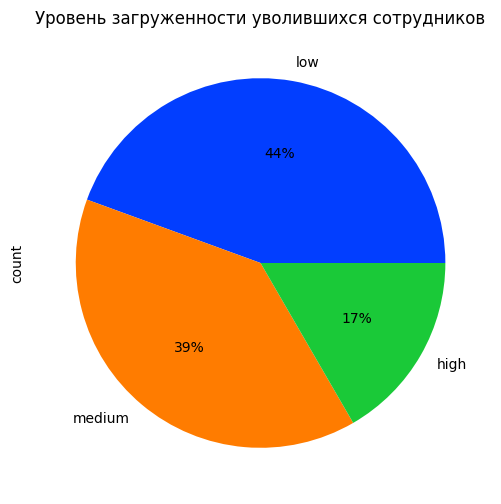

In [41]:
palette_color = sns.color_palette('bright')
train2.loc[train2['quit'] == 'yes', 'workload'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень загруженности уволившихся сотрудников', colors = palette_color, figsize = (6, 6))
plt.show()

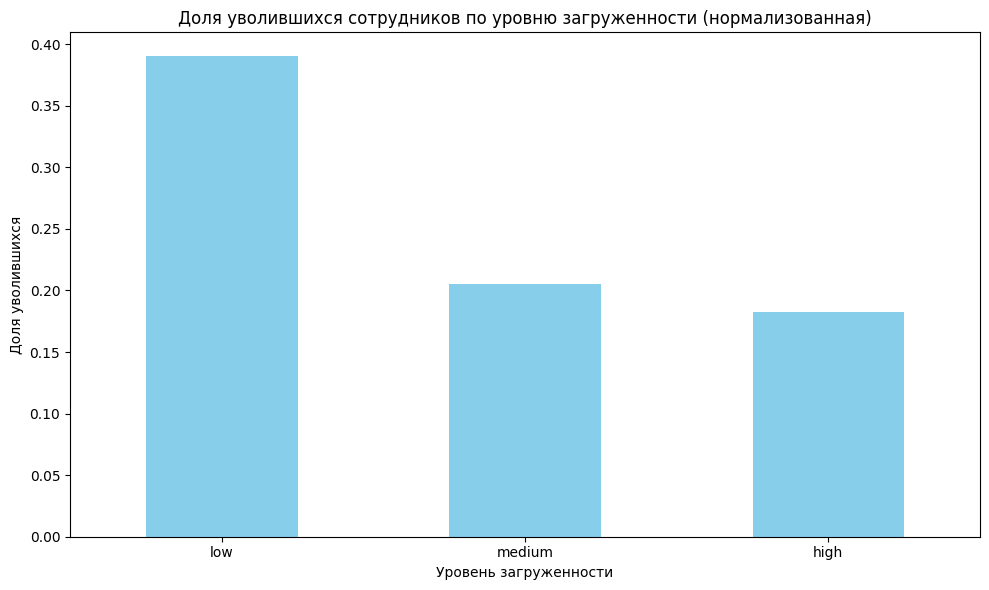

workload
low       0.390080
medium    0.204984
high      0.182580
Name: yes, dtype: float64


In [44]:
workload_quit_rate = train2.groupby('workload')['quit'].value_counts(normalize=True).unstack()

# 2. Выбор только доли уволившихся (quit == 'yes')
quit_yes_rate = workload_quit_rate['yes']

quit_yes_rate = quit_yes_rate.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
quit_yes_rate.plot(kind='bar', color='skyblue')
plt.title('Доля уволившихся сотрудников по уровню загруженности (нормализованная)')
plt.xlabel('Уровень загруженности')
plt.ylabel('Доля уволившихся')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(quit_yes_rate)

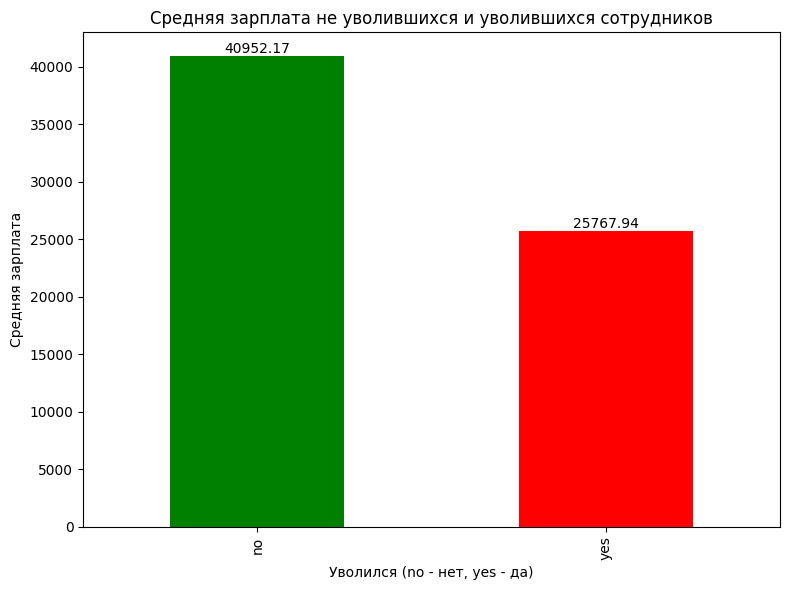

In [45]:
average_salary_by_quit = train2.groupby('quit')['salary'].mean()

plt.figure(figsize=(8, 6))  # Optional: Adjust figure size

average_salary_by_quit.plot(kind='bar', color=['green', 'red']) # Choose colors for bars
plt.title('Средняя зарплата не уволившихся и уволившихся сотрудников')
plt.xlabel('Уволился (no - нет, yes - да)')
plt.ylabel('Средняя зарплата')

# Добавляем значения на столбцы для лучшей читаемости
for i, v in enumerate(average_salary_by_quit):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')


plt.tight_layout()
plt.show()

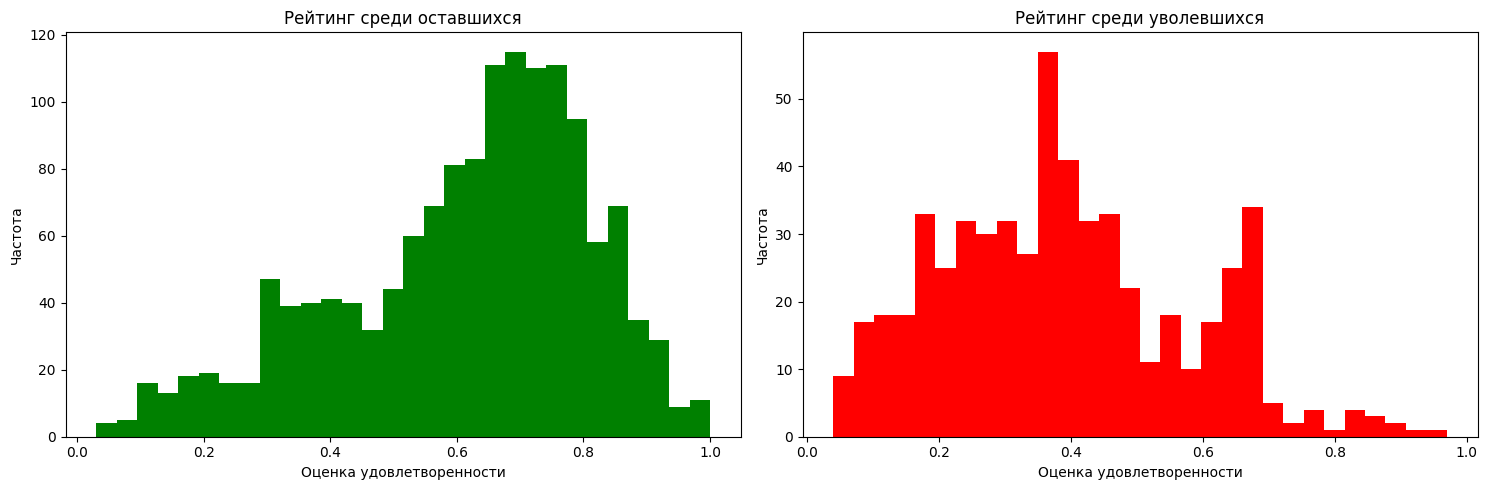

In [46]:
rate = pd.merge(y_test,y_test2, on = 'id')
rate_yes = rate[rate['quit'] == 'yes']
rate_no = rate[rate['quit'] == 'no']

plt.figure(figsize=(15, 5))
# Первая гистограмма
plt.subplot(1, 2, 1)
plt.hist(rate_no['job_satisfaction_rate'], bins=30, color='green')
plt.title('Рейтинг среди оставшихся')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

# Вторая гистограмма
plt.subplot(1, 2, 2)
plt.hist(rate_yes['job_satisfaction_rate'], bins=30, color='red')
plt.title('Рейтинг среди уволевшихся')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Больше всего уволилось продажников. Но если смотреть относительно кол-ва то закупщики чаще увольняются. Уволившиеся в среднем получают зарплату ниже, на 15к, чем оставшиеся. Также рейтинг среди уволевшихся ближе к 0.4, чем у оставшихся (0.7).

## Шаг 4. Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [47]:
train2['job_satisfaction_rate'] = grid_search.predict(train2.drop(['quit'], axis = 1))
X_test2['job_satisfaction_rate'] = grid_search.predict(X_test2)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Добавили новый столбец.

## Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [48]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

y = train2['quit']
X = train2.drop(['quit'], axis = 1)

ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
])

ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','senior'],
                    ['low','medium','high']
                ],
                handle_unknown='use_encoded_value',  # Recommended for robustness
                unknown_value=-1
            )
        ),
       (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder =  'passthrough'
)

pipe_final= Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Подготовили данные для пайплайна, далее обучим модель.

## Шаг 6. Обучение моделей

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [49]:
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [50]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [51]:
# Получаем результаты кросс-валидации
cv_results = pd.DataFrame(randomized_search.cv_results_)

# Сортируем результаты по убыванию ROC AUC (так как ROC AUC максимизируется, то лучшее значение - максимальное)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)

# Выводим топ-10 моделей
print("Топ-10 моделей:")
print(cv_results[['params', 'mean_test_score']].head(10))

# Выводим лучшую модель и метрику
print(f'Лучшая модель: {randomized_search.best_estimator_}')
print(f'Метрика лучшей модели на кросс-валидации: {randomized_search.best_score_}')

Топ-10 моделей:
                                              params  mean_test_score
6  {'preprocessor__num': StandardScaler(), 'model...         0.894743
9  {'preprocessor__num': MinMaxScaler(), 'models_...         0.887872
2  {'preprocessor__num': 'passthrough', 'models__...         0.878447
5  {'preprocessor__num': MinMaxScaler(), 'models_...         0.877670
8  {'preprocessor__num': 'passthrough', 'models__...         0.873076
1  {'preprocessor__num': MinMaxScaler(), 'models_...         0.843014
3  {'preprocessor__num': StandardScaler(), 'model...         0.842859
7  {'preprocessor__num': StandardScaler(), 'model...         0.835328
4  {'preprocessor__num': StandardScaler(), 'model...         0.804777
0  {'preprocessor__num': MinMaxScaler(), 'models_...         0.747760
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                 

In [52]:
X_test2 = X_test2.sort_values(by = 'id')
y_test2 = y_test2.sort_values(by = 'id')

In [53]:
y_predict_proba = randomized_search.predict_proba(X_test2)
y_predict_proba

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[0.82857143, 0.17142857],
       [0.9       , 0.1       ],
       [0.96345515, 0.03654485],
       ...,
       [0.1048951 , 0.8951049 ],
       [0.96984925, 0.03015075],
       [0.168     , 0.832     ]])

In [54]:
roc_auc_score(y_test2, y_predict_proba[:, 1])

np.float64(0.9239675319544045)

## Шаг 7. Вывод

Обучили несколько моделей, лучшая
'models' DecisionTreeClassifier(max_depth=6, max_features=8, random_state=42),
с метрикой ROC_AUC, которая показала на тестовой выборке значение 0.92, что удовлетворяет нашей задаче.

## Общий вывод

Вывод по 1 задаче: Обучили несколько моделей, лучшая 'models', RandomForestRegressor(random_state=42), с метрикой SMAPE равной 14 на тренеровочной выборке. Тестовая выборка показала результат 12. Что меньше 15 и подходит нам по заданию.

Вывод по 2 задаче: Обучили несколько моделей, лучшая 'models' DecisionTreeClassifier(max_depth=6, max_features=6, random_state=42), с метрикой ROC_AUC, которая показала на тестовой выборке значение 0.91, что удовлетворяет нашей задаче.

Выполнили 2 задачи. 1 задача - построить модель, которая будет предсказывать уровень удовлетворенности работников. 2 задача - построить модель, которая будет предсказывать, уволится сотрудник или нет, что позволит уменьшит текучку кадров в фирме. При решении задач были проведены следующие этапы: Загрузка данныХ. обработка, анализ и подготовка данных к обучению модели и само обучение.
Вот некоторые рекомендации:
Больше всего уволилось сотрудников из отдела продажь, а если относительно кол-ва то закупщики. Стоит узнать в чем дело, что не устраивает сотрудников.
В среднем зарплаты меньше у уволившихся на 15к, возможно стоит увеличить зарплаты.